In [5]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [6]:
data_train = pd.read_csv('data/train.csv')
X_test = pd.read_csv('data/test.csv')
data = data_train.append(X_test, ignore_index=True, sort=False)
data = pd.get_dummies(data, dummy_na=True, drop_first=True)
data.drop('Id', axis=1, inplace=True)
data.isnull().values.any()

True

In [7]:
data.fillna(data.median(), inplace=True)
columns = data.columns
sale_price = data['SalePrice']
data.isnull().values.any()

False

In [8]:
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = columns)
data['SalePrice'] = sale_price
data.head()

/home/norvilr/anaconda3/envs/torch10/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 289 entries, MSSubClass to SaleCondition_nan
dtypes: float64(289)
memory usage: 6.4 MB


In [29]:
data['SalePrice'].head()

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

In [9]:
train = data.iloc[:1460]
test = data.iloc[1460:]
test.drop('SalePrice', axis=1, inplace=True)

/home/norvilr/anaconda3/envs/torch10/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('SalePrice', axis=1), train['SalePrice'], test_size=0.2, random_state=42)

In [11]:
X_train.shape

(1168, 288)

In [12]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(288, 144)
        self.fc2 = nn.Linear(144, 72)
        self.fc3 = nn.Linear(72, 18)
        self.fc4 = nn.Linear(18, 1)

        #self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):

        #x = self.dropout(F.relu(self.fc1(x)))
        #x = self.dropout(F.relu(self.fc2(x)))
        #x = self.dropout(F.relu(self.fc3(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        return x

In [13]:
train_batch = np.array_split(X_train, 50)
label_batch = np.array_split(y_train, 50)

In [14]:
for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)

X_val = torch.from_numpy(X_val.values).float()
y_val = torch.from_numpy(y_val.values).float().view(-1, 1)

In [15]:
model = Regressor()
ps = model(train_batch[0])
ps.shape

torch.Size([24, 1])

In [23]:
model

Regressor(
  (fc1): Linear(in_features=288, out_features=144, bias=True)
  (fc2): Linear(in_features=144, out_features=72, bias=True)
  (fc3): Linear(in_features=72, out_features=18, bias=True)
  (fc4): Linear(in_features=18, out_features=1, bias=True)
)

In [16]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 300

train_losses, test_losses = [], []
for e in range(epochs):
    model.train()
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        loss = torch.sqrt(criterion(torch.log(output), torch.log(label_batch[i])))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_val)
            test_loss += torch.sqrt(criterion(torch.log(predictions), torch.log(y_val)))
                
        train_losses.append(train_loss/len(train_batch))
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(train_batch)),
              "Test Loss: {:.3f}.. ".format(test_loss))

Epoch: 1/300..  Training Loss: 11.335..  Test Loss: 9.221.. 
Epoch: 2/300..  Training Loss: 8.226..  Test Loss: 7.357.. 
Epoch: 3/300..  Training Loss: 6.814..  Test Loss: 6.266.. 
Epoch: 4/300..  Training Loss: 5.897..  Test Loss: 5.493.. 
Epoch: 5/300..  Training Loss: 5.208..  Test Loss: 4.876.. 
Epoch: 6/300..  Training Loss: 4.646..  Test Loss: 4.368.. 
Epoch: 7/300..  Training Loss: 4.179..  Test Loss: 3.940.. 
Epoch: 8/300..  Training Loss: 3.781..  Test Loss: 3.570.. 
Epoch: 9/300..  Training Loss: 3.432..  Test Loss: 3.243.. 
Epoch: 10/300..  Training Loss: 3.121..  Test Loss: 2.948.. 
Epoch: 11/300..  Training Loss: 2.839..  Test Loss: 2.680.. 
Epoch: 12/300..  Training Loss: 2.582..  Test Loss: 2.434.. 
Epoch: 13/300..  Training Loss: 2.344..  Test Loss: 2.204.. 
Epoch: 14/300..  Training Loss: 2.119..  Test Loss: 1.987.. 
Epoch: 15/300..  Training Loss: 1.907..  Test Loss: 1.783.. 
Epoch: 16/300..  Training Loss: 1.710..  Test Loss: 1.594.. 
Epoch: 17/300..  Training Loss: 

Epoch: 136/300..  Training Loss: 0.123..  Test Loss: 0.172.. 
Epoch: 137/300..  Training Loss: 0.122..  Test Loss: 0.171.. 
Epoch: 138/300..  Training Loss: 0.122..  Test Loss: 0.171.. 
Epoch: 139/300..  Training Loss: 0.121..  Test Loss: 0.170.. 
Epoch: 140/300..  Training Loss: 0.121..  Test Loss: 0.170.. 
Epoch: 141/300..  Training Loss: 0.120..  Test Loss: 0.170.. 
Epoch: 142/300..  Training Loss: 0.119..  Test Loss: 0.169.. 
Epoch: 143/300..  Training Loss: 0.119..  Test Loss: 0.169.. 
Epoch: 144/300..  Training Loss: 0.118..  Test Loss: 0.168.. 
Epoch: 145/300..  Training Loss: 0.118..  Test Loss: 0.168.. 
Epoch: 146/300..  Training Loss: 0.117..  Test Loss: 0.168.. 
Epoch: 147/300..  Training Loss: 0.117..  Test Loss: 0.167.. 
Epoch: 148/300..  Training Loss: 0.116..  Test Loss: 0.167.. 
Epoch: 149/300..  Training Loss: 0.116..  Test Loss: 0.166.. 
Epoch: 150/300..  Training Loss: 0.115..  Test Loss: 0.166.. 
Epoch: 151/300..  Training Loss: 0.115..  Test Loss: 0.166.. 
Epoch: 1

Epoch: 270/300..  Training Loss: 0.080..  Test Loss: 0.151.. 
Epoch: 271/300..  Training Loss: 0.079..  Test Loss: 0.151.. 
Epoch: 272/300..  Training Loss: 0.079..  Test Loss: 0.151.. 
Epoch: 273/300..  Training Loss: 0.079..  Test Loss: 0.151.. 
Epoch: 274/300..  Training Loss: 0.079..  Test Loss: 0.151.. 
Epoch: 275/300..  Training Loss: 0.079..  Test Loss: 0.151.. 
Epoch: 276/300..  Training Loss: 0.078..  Test Loss: 0.151.. 
Epoch: 277/300..  Training Loss: 0.078..  Test Loss: 0.151.. 
Epoch: 278/300..  Training Loss: 0.078..  Test Loss: 0.151.. 
Epoch: 279/300..  Training Loss: 0.078..  Test Loss: 0.151.. 
Epoch: 280/300..  Training Loss: 0.078..  Test Loss: 0.151.. 
Epoch: 281/300..  Training Loss: 0.078..  Test Loss: 0.151.. 
Epoch: 282/300..  Training Loss: 0.077..  Test Loss: 0.151.. 
Epoch: 283/300..  Training Loss: 0.077..  Test Loss: 0.151.. 
Epoch: 284/300..  Training Loss: 0.077..  Test Loss: 0.151.. 
Epoch: 285/300..  Training Loss: 0.077..  Test Loss: 0.151.. 
Epoch: 2

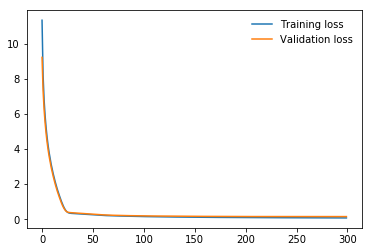

In [17]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [18]:
test = torch.from_numpy(test.values).float()

with torch.no_grad():
    model.eval()
    output = model.forward(test)

output.shape

torch.Size([1459, 1])

In [24]:
print(output)

tensor([[128283.6875],
        [157806.5938],
        [178393.7500],
        ...,
        [163115.5156],
        [112040.8750],
        [203125.7656]])


In [21]:
submission = pd.read_csv('data/sample_submission.csv')
submission['SalePrice'] = output.numpy()
submission.to_csv('Regression_submission.csv', index=False)

In [22]:
submission

,Id,SalePrice
0,1461,128283.687500
1,1462,157806.593750
2,1463,178393.750000
3,1464,183896.296875
4,1465,192994.140625
5,1466,177651.031250
6,1467,170787.812500
7,1468,161059.968750
8,1469,176284.171875
9,1470,133028.343750
